### Gerry's (BL) graph partition algorithm.
Notes: Hi Hugo, today I was experimenting with the graph for the partitioning.  
I came up with this greedy function that seems to work fine.  
There is a  little bit of randomness involved, you may want to play with the parameters  
until you find a suitable partition. You cannot select the number of partitions,  
instead you set the max and min number of nodes for each group (the max  
is not guaranteed). Still, this is a partition on the vertexes, so you  still  
need to do something for the edges.  
Let me know if you have  questions, hope it helps.  
-  
Notes  
NetworkX graph algos: https://networkx.org/documentation/stable/reference/algorithms/approximation.html#module-networkx.algorithms.approximation.maxcut  
Cuts (graph theory): https://en.wikipedia.org/wiki/Cut_(graph_theory)

In [1]:
!pip install /content/drive/MyDrive/'Colab Notebooks'/'Water Distribution Network'/Simulators/network-simulator/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./drive/MyDrive/Colab Notebooks/Water Distribution Network/Simulators/network-simulator
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 4.4 MB 26.1 MB/s 
  Created wheel for network-simulator: filename=network_simulator-0.0.5-py3-none-any.whl size=5671 sha256=382c2226e85a8e151ff634a0320e4cd609f53c159ae97b817d6de6df4d4c56f8
  Stored in directory: /root/.cache/pip/wheels/54/3d/11/50b3bdca49fbf448c30adef2595050d18a0a14e65211650115
Successfully built network-simulator


In [2]:
import random
import networkx as nx
from collections import deque
from typing import List
from network_simulator import WaterNetworkSimulator

import numpy as np   # for saving groups list
import pickle   # for saving reg_dict
import pathlib
import datetime   # for saved filenms

/usr/local/lib/python3.7/dist-packages/wntr/epanet/io.py:2082: UserWarning: Not all curves were used in "/content/drive/MyDrive/Colab Notebooks/Water Distribution Network/Simulators/GerryR89-network-simulator-v2/networks/bwcn8-168-true.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
max: 1, min: 12
grps_len: 21
grp0_len: 12
max group size 31


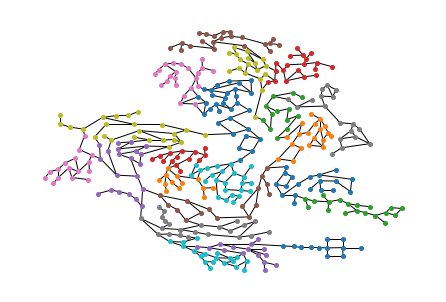

In [68]:
# Gerry's (BL) graph partition function.
def greedy_partitioner(graph: nx.Graph, max_subgraph_nodes: int, min_subgraph_nodes: int) -> List[List[str]]:
    """Note that each call produces a new (random) partition.
    """
    test = False
    # STEP 1:
    # Partition the graph into connected groups, each group cannot be bigger than max_subgraph_nodes

    available_nodes = list(graph.nodes)

    groups = []
    while available_nodes:
        group = []
        # Get a random node
        node = random.choice(available_nodes)

        # Search available neighbor nodes
        neighbor_nodes = deque([node])
        while neighbor_nodes and len(group) < max_subgraph_nodes:
            next_node = neighbor_nodes.popleft()

            group.append(next_node)
            available_nodes.remove(next_node)

            for neighbor_node in graph.neighbors(next_node):
                if neighbor_node in available_nodes and neighbor_node not in neighbor_nodes:
                    neighbor_nodes.append(neighbor_node)

        # Store the new group
        groups.append(group)

    # Hugo's test code:
    if test :
      print()
      print(f'Step1:')
      print(f'group cnt: {len(groups)}')
      print(f'max group len: {len(max(groups, key=len))} (expect {max_subgraph_nodes})')
      print()
    # assert 0

    # Sort the groups by their size
    groups.sort(key=len)

    # STEP 2:
    # Merge all the groups with less than min_subgraph_nodes to a neighbor group
    if test :
      print(f'Step2:')

    while len(groups[0]) < min_subgraph_nodes:
        # Get the smallest group
        group = groups.pop(0)

        # Search for the neighbor group with the smallest number of nodes
        other_group_id = None
        other_group_size = 1e15
        # print(f'group len: {len(group)}')
        for i, other_group in enumerate(groups):
            # print(f'for inside while: i {i}')
            if len(other_group) < other_group_size:
                for node in other_group:
                    # Bitwise and (&) on sets returns the elements that are in both sets
                    if set(graph.neighbors(node)) & set(group):
                        other_group_id = i
                        other_group_size = len(group)
                        # print(f'other group size: {other_group_size}')
                        # print('breaking ... inner for loop')
                        break

        # Merge the 2 groups
        groups[other_group_id].extend(group)

        # Sort the groups by their size
        groups.sort(key=len)

    if test :
      print(f'greedy_part complete.\n')

    return groups

# Path to the inp file
inp_file = ('/content/drive/MyDrive/Colab Notebooks/Water Distribution ' + 
            'Network/Simulators/GerryR89-network-simulator-v2/networks/bwcn8-168-true.inp')

# Create instance of WNS
wn_sim = WaterNetworkSimulator(inp_file)

# Get the network in a NetworkX format
graph = wn_sim.wn.get_graph()
undirected_graph = graph.to_undirected()

# Graph partitioning
maxim = 1
minim = 12
# groups = greedy_partitioner(graph.to_undirected(), maxim, minim)
# print(f'max: {maxim}, min: {minim}')
# print(f'grps_len: {len(groups)}')
# print(f'grp0_len: {len(groups[0])}')
# # print(f'grp type: {type(groups[0])}')
# # print(type(max))
# print(f'max group size {len(max(groups, key=len))}')

for i in range(10000) :
  if i % 100 == 0 :
    print(i)
  groups = greedy_partitioner(graph.to_undirected(), maxim, minim)
  if len(groups) == 30 :
    print('\n breaking for loop ...')
    break
print(f'max: {maxim}, min: {minim}')
print(f'grps_len: {len(groups)}')
print(f'grp0_len: {len(groups[0])}')
print(f'max group size {len(max(groups, key=len))}')

# Draw the graph
nx.draw(undirected_graph, pos=nx.get_node_attributes(undirected_graph, "pos"), node_size=0)
for i, group in enumerate(groups):
    nx.draw_networkx_nodes(undirected_graph,
                           pos=nx.get_node_attributes(undirected_graph, "pos"),
                           nodelist=group,
                           node_size=16,
                           node_color=f"C{i}",
                           )

In [64]:
# Save partitioned graph to disk.
# Careful: Before running cell, double check destination path and intent to save.
#  The old partition is lost (none recoverable) each time greedy_partition()
#  is called. i.e. a new and different partition is created randomly.
#  This new partition may overwrite the old one.

# If next block works, delete this block.
# dttm = datetime.datetime.now().strftime("%m-%d-%Y_%H%M_%S")
# dir_path = '/content/drive/MyDrive/Colab Notebooks/Water Distribution Network/Input Pipeline/Datasets/leak_pipes_all/'
# file_nm = f'regions_ls_{len(groups)}_{dttm}.npy'
# save_loc = dir_path + file_nm
# grps = np.asanyarray(groups, dtype=object)
# np.save(save_loc, grps,)

dttm = datetime.datetime.now().strftime("%m-%d-%Y_%H%M_%S")
dir_path = f'/content/drive/MyDrive/Colab Notebooks/Water Distribution Network/Input Pipeline/Datasets/leak_pipes_all/{len(groups)}regions/'
version = '00/'   # !!!Update if using alternate region partition w/ the same region count as a previous partition.!!!
file_nm = f'regions_ls_{len(groups)}_{dttm}.npy'
dest_dir = dir_path + version
save_loc = dest_dir + file_nm

# Create destination directory if does not exist.
p = pathlib.Path(dest_dir)
if not p.exists() :
  # Parent dir must exist. i.e. all but the new folder in the line of folders must already exist.
  # p.mkdir()
  p.mkdir(parents=True)

grps = np.asanyarray(groups, dtype=object)
np.save(save_loc, grps,)

In [70]:
# Load node partitioned graph (regions) for use in edge partitioning.
dir_path = '/content/drive/MyDrive/Colab Notebooks/Water Distribution Network/Input Pipeline/Datasets/leak_pipes_all/30regions/00/'
# file_nm = f'regions_ls_{len(groups)}.npy'
# file_nm = f'regions_ls_11.npy'
file_nm = f'regions_ls_30_05-31-2022_2049_26.npy'
load_loc = dir_path + file_nm
regions_ls = np.load(load_loc, allow_pickle='TRUE')

In [ ]:
# for group in regions_ls :
#   print(group)

In [71]:
# Create disjoint partitions of graph edges (pipes).
# Assign pipes to respective regions.

# Path to the inp file
inp_file = ('/content/drive/MyDrive/Colab Notebooks/Water Distribution Network/' + 
            'Simulators/GerryR89-network-simulator-v2/networks/bwcn8-168-true.inp')

# Create instance of WNS
wn_sim = WaterNetworkSimulator(inp_file)

# Get the network in a NetworkX format
graph = wn_sim.wn.get_graph()
undirected_graph = graph.to_undirected()

# Get edges
# Loop thru all edges,
#  if edge has both endpts in the same region, then assign edge to region idx
#  else if edge has endpts in two regions, then assign to one or the other and note it as a boundary
# ensure edges exists in only in region.
# result: disjoint partition of edges.

# Get edges
edges = graph.edges.keys()
# print(edges)
# Loop thru all edges,
bound_edge = {}
reg_partit = {}
for i, region in enumerate(regions_ls) :
  # print(edge[1])
  edge_ls = []
#  if edge has both endpts in the same region, then assign edge to region idx
  for edge in edges :
    if edge[0] in region and edge[1] in region :
      # print(f'pipe is in reg{i}')
      # print(f'pipe {edge[2]}, j0 {edge[0]}, j1 {edge[1]}')
      # print(f'region node {region}')
      # assert False
      edge_ls.append(edge[2])
#  else if edge has endpts in two regions, then assign edge to one or the other and **note it as a boundary**
#    consider adding endpt nodes for boundary edges in the list as list of tuples [(reg, node_in_reg), ( )].
    elif edge[0] in region or edge[1] in region :
      if edge[2] not in bound_edge :
        bound_edge[ edge[2] ] = [i]
        # print('not in dict')
        # print(bound_edge[ edge[2] ])
        # print(f'pipe {edge[2]}, j0 {edge[0]}, j1 {edge[1]}')
        # assert False
      else :
        bound_edge[ edge[2] ].append(i)
        # print('append dict')
        # print(bound_edge[ edge[2] ])
        # print(f'pipe {edge[2]}, j0 {edge[0]}, j1 {edge[1]}')
        # print(f'region node {region}')
        # print(bound_edge)
        # assert False
  # print(edge_ls)
  reg_partit[f'reg{i}'] = edge_ls
  # print("for loop: iter end")

#  else if edge has endpts in two regions, then **assign edge to one or the other** and note it as a boundary
# bound_edge -- key: pipe_nm (str), val: (end_reg, end_reg) i.e. the two regions key is in; do this tho -- val: (owner_reg, edge_reg) 
for i, edge in enumerate(bound_edge) :
  # alternate reg assignment by ls idx
  # print(i%2)
  # print(edge)
  # print(f'reg: {bound_edge[edge][i % 2]}')
  # reg_asign = bound_edge[edge][i % 2]
  # reg_partit[f'reg{reg_asign}'].append(edge)
  # assign edge to smaller region (based on region edge cnt)
  reg_idx0 = bound_edge[edge][0]
  reg_0 = reg_partit[f'reg{reg_idx0}']
  reg_idx1 = bound_edge[edge][1]
  reg_1 = reg_partit[f'reg{reg_idx1}']
  # print('reg lens:', len(reg_0), len(reg_1))
  if len(reg_0) < len(reg_1) :
    reg_partit[f'reg{reg_idx0}'].append(edge)
  elif len(reg_0) > len(reg_1) :
    reg_partit[f'reg{reg_idx1}'].append(edge)
  else :
    reg_asign = bound_edge[edge][i % 2]
    reg_partit[f'reg{reg_asign}'].append(edge)

# print(reg_partit)
# print(bound_edge)
# print(len(bound_edge))
# dict of dicts (parts and bndry)
reg_dict = {}
reg_dict['reg_partits'] = reg_partit
reg_dict['bndry_edges'] = bound_edge
print(len(reg_dict), reg_dict)
print(f'max reg len: {len(max(reg_partit.values(), key=len))}')

# ensure edges exists in only one region.
mistake = False
for ireg in reg_partit.values() :
  if mistake :
    print('breaking main for loop')
    break
  for jreg in reg_partit.values() :
    # if (ireg == jreg) :
    #   print('ls match')
    # elif (ireg != jreg) :
    #   print('ls don\'t match')
    if ireg == jreg : 
      # print('breaking out')
      break
    if mistake :
      print('breaking nested for loop')
      break
    for pipe in ireg :
      # print(pipe)
      if (ireg != jreg) and (pipe in jreg) :
        print('Mistake', pipe)
        mistake = True
        break
# mistake = True
if not mistake :
  print('\nTest: Pass! *** Edges form discrete partitions ***\n')
else :
  print('\nTest: !FAIL -- Mistake found. Others may exist.\n')
# expected result: disjoint partition of edges saved to folder where training cvs files will be stored.
#  update: save to parent folder of all tmstp data used for this particular edge partition.

2 {'reg_partits': {'reg0': ['P804', 'P889', 'P801', 'P241', 'P800', 'P798', 'P807', 'P805', 'P806', 'P795'], 'reg1': ['P237', 'P292', 'P291', 'P308', 'P293', 'P238', 'P380', 'PU6', 'PU7', 'P381', 'P252', 'P305'], 'reg2': ['P892', 'P96', 'P445', 'P465', 'P307', 'P301', 'P298', 'P484', 'P302', 'P443', 'P297', 'P446', 'P296'], 'reg3': ['P220', 'P927', 'P9', 'P21', 'P991', 'P8', 'P5', 'P992', 'P138', 'P993', 'P20', 'P69', 'P999'], 'reg4': ['P338', 'P346', 'P330', 'P339', 'P329', 'P348', 'P349', 'P347', 'P350', 'P524'], 'reg5': ['P233', 'P10', 'P234', 'P235', 'P13', 'P12', 'P139', 'P14', 'P15', 'P7', 'P159'], 'reg6': ['P779', 'P783', 'P785', 'P786', 'P784', 'P787', 'P788', 'P791', 'P797', 'P794', 'P777', 'P796'], 'reg7': ['P158', 'P823', 'P826', 'P157', 'P827', 'P154', 'P830', 'P160', 'P831', 'P162', 'P246', 'P248', 'P44', 'P266', 'P57'], 'reg8': ['P450', 'P215', 'P287', 'P468', 'P467', 'P374', 'P375', 'P378', 'PU4', 'P376', 'PU5', 'P379', 'V2'], 'reg9': ['P127', 'P126', 'P132', 'P258', 'P9

/usr/local/lib/python3.7/dist-packages/wntr/epanet/io.py:2082: UserWarning: Not all curves were used in "/content/drive/MyDrive/Colab Notebooks/Water Distribution Network/Simulators/GerryR89-network-simulator-v2/networks/bwcn8-168-true.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


In [72]:
# Careful: new partition will overwrite old partition.
reg_pts = reg_dict['reg_partits']
dttm = datetime.datetime.now().strftime("%m-%d-%Y_%H%M_%S")
# dir_path = f'/content/drive/MyDrive/Colab Notebooks/Water Distribution Network/Input Pipeline/Datasets/leak_pipes_all/tmstp80/regionAndPipeLabels/11regions/'
dir_path = f'/content/drive/MyDrive/Colab Notebooks/Water Distribution Network/Input Pipeline/Datasets/leak_pipes_all/{len(reg_pts)}regions/'
version = '00/'   # !!!Update if using alternate region partition w/ the same region count as a previous partition.!!!
# file_nm = f'region_dict_{len(reg_pts)}_{dttm}.pickle'
file_nm = f'region_dict_{len(reg_pts)}_{dttm}.pickle'
dest_dir = dir_path + version
save_loc = dest_dir + file_nm
# save_loc = dir_path + file_nm

# Create destination directory if does not exist.
p = pathlib.Path(dest_dir)
# print(dest_dir)
# print(p)
# print(p.exists())
if not p.exists() :
  # Parent dir must exist. i.e. all but the new folder in the line of folders must already exist.
  # p.mkdir()
  p.mkdir(parents=True)

with open(save_loc, 'wb') as handle:
    pickle.dump(reg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# For loading
# with open(load_loc, 'rb') as handle:
#     reg_dict = pickle.load(handle)

In [ ]:
'stop' in ['stop', 'go'] or 'go' in ['stop', 'go']

True

In [ ]:
# How to pickle a file.
import pickle

a = {'hello': 'world'}

with open('filename.pickle', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('filename.pickle', 'rb') as handle:
    b = pickle.load(handle)

print(a == b)
print(a)

# Almost any python object will work.
# Stackoverflow: This same approach will will work for many Python objects, including instances of arbitrary classes and arbitrarily complex nestings of data structures. For example, replacing the second line with these lines
import datetime
today = datetime.datetime.now()
a = [{'hello': 'world'}, 1, 2.3333, 4, True, "x", 
     ("y", [[["z"], "y"], "x"]), {'today', today}]

True
{'hello': 'world'}


In [ ]:
print(next(iter(reg_dict['reg_partits'].values())))
# for reg in reg_dict['reg_partits'].values() :
#   print(reg)

['P769', 'P756', 'P94', 'P755', 'P95', 'P763', 'P767', 'P768', 'P771', 'P772', 'P775', 'P777', 'P776', 'P779', 'P783', 'P785', 'P786', 'P784', 'P787', 'P788', 'P797', 'P791']


In [ ]:
ls1 = ['0', 1]
ls2 = ['0', 1]
ls1 == ls2

False

In [ ]:
print(datetime.datetime.now().strftime("%m-%d-%Y_%H%M_%S"))
print(type(datetime.datetime.now().strftime("%m-%d-%Y_%H%M_%S")))

05-18-2022_2257_14
<class 'str'>
